In [1]:
'''
    Opening notebook remotely on MacOS --> jupyter-notebook --no-browser --port=9090
'''

'\n    Opening notebook remotely on MacOS --> jupyter-notebook --no-browser --port=9090\n'

In [2]:
!echo $CUDA_VISIBLE_DEVICES

1


In [3]:
from sklearn.metrics import classification_report
from keras.models import load_model
import numpy as np
from sklearn.metrics import roc_curve, auc, confusion_matrix
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
import seaborn as sns

2023-11-28 19:43:26.155417: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [4]:
shared_dir = "/s/bach/a/class/cs435/cs435a/"
image_dir = "CS435_Plant_Data_v2_augment-v2/2023-11-15-231056/"

orig_test = "splits/original_grouped/orig_test.csv"
aug_test = "splits/augmented_grouped/aug_test.csv"

orig_test_path = shared_dir+image_dir+orig_test
aug_test_path = shared_dir+image_dir+aug_test

In [5]:
orig_model_name = shared_dir + "models/trained_original_grouped.h5"
aug_model_name = shared_dir + "models/trained_augmented_grouped.h5"
orig_model = load_model(orig_model_name)
aug_model = load_model(aug_model_name)

2023-11-28 19:43:29.502016: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-28 19:43:30.068006: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9646 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1b:00.0, compute capability: 7.5


In [6]:
orig_test_df = pd.read_csv(orig_test_path)
aug_test_df = pd.read_csv(aug_test_path)

datagen = ImageDataGenerator(rescale=1./255) #normalize from [0,255] to [0,1]
orig_test_generator = datagen.flow_from_dataframe(
    dataframe=orig_test_df, 
    x_col='path_to_shared',
    y_col='class_name',  
    target_size=(224, 224),
    batch_size=10,
    class_mode='categorical', 
    shuffle=False
)

aug_test_generator = datagen.flow_from_dataframe(
    dataframe=aug_test_df, 
    x_col='path_to_shared',
    y_col='class_name',  
    target_size=(224, 224),
    batch_size=10,
    class_mode='categorical', 
    shuffle=False
)

Found 7330 validated image filenames belonging to 31 classes.
Found 21990 validated image filenames belonging to 31 classes.


In [7]:
rain_test_df = aug_test_df[aug_test_df['augmentation'].str.contains('rain', case=False, na=False)]
mud_test_df = aug_test_df[aug_test_df['augmentation'].str.contains('mud', case=False, na=False)]

rain_test_generator = datagen.flow_from_dataframe(
    dataframe=rain_test_df, 
    x_col='path_to_shared',
    y_col='class_name',  
    target_size=(224, 224),
    batch_size=10,
    class_mode='categorical', 
    shuffle=False
)

mud_test_generator = datagen.flow_from_dataframe(
    dataframe=mud_test_df, 
    x_col='path_to_shared',
    y_col='class_name',  
    target_size=(224, 224),
    batch_size=10,
    class_mode='categorical', 
    shuffle=False
)

Found 7330 validated image filenames belonging to 31 classes.
Found 7330 validated image filenames belonging to 31 classes.


In [8]:
# Basic metrics: accuracy, precision, recall, f1-score
def evaluate_model_metrics(model, test_generator, predictions):
    predicted_classes = [np.argmax(pred) for pred in predictions]

    true_classes = test_generator.classes

    class_labels = list(test_generator.class_indices.keys())

    report = classification_report(true_classes, predicted_classes, target_names=class_labels, output_dict=True)
    return report

In [9]:
def print_report(report):
    report_df = pd.DataFrame(report).transpose()
    
    print(f"Accuracy: {report_df.loc['accuracy', 'precision']}")
    print(f"Macro Average Precision: {report_df.loc['macro avg', 'precision']}")
    print(f"Macro Average Recall: {report_df.loc['macro avg', 'recall']}")
    print(f"Macro Average F1-Score: {report_df.loc['macro avg', 'f1-score']}")

    display(report_df)

In [10]:
print("*** EVALUATING MODEL TRAINED ON ORIGINAL DATA ***")
orig_orig_predictions = orig_model.predict(orig_test_generator)
orig_aug_predictions = orig_model.predict(aug_test_generator)
orig_rain_predictions = orig_model.predict(rain_test_generator)
orig_mud_predictions = orig_model.predict(mud_test_generator)

orig_orig_test_report = evaluate_model_metrics(orig_model, orig_test_generator, orig_orig_predictions)
orig_aug_test_report = evaluate_model_metrics(orig_model, aug_test_generator, orig_aug_predictions)
orig_rain_test_report = evaluate_model_metrics(orig_model, rain_test_generator, orig_rain_predictions)
orig_mud_test_report = evaluate_model_metrics(orig_model, mud_test_generator, orig_mud_predictions)

*** EVALUATING MODEL TRAINED ON ORIGINAL DATA ***


2023-11-28 19:43:43.089425: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8201


733/733 [==============================] - 21s 28ms/step


In [11]:
print("*** EVALUATIONS ON ORIGINAL TEST DATA WITH MODEL TRAINED ON ORIGINAL DATA ***")
print_report(orig_orig_test_report)

print("*** EVALUATIONS ON AUGMENTED TEST DATA WITH MODEL TRAINED ON ORIGINAL DATA ***")
print_report(orig_aug_test_report)

print("*** EVALUATIONS ON ONLY RAIN SPATTER AUGMENTED IMAGES WITH MODEL TRAINED ON ORIGINAL DATA ***")
print_report(orig_rain_test_report)

print("*** EVALUATIONS ON ONLY MUD SPATTER AUGMENTED IMAGES WITH MODEL TRAINED ON ORIGINAL DATA ***")
print_report(orig_mud_test_report)

*** EVALUATIONS ON ORIGINAL TEST DATA WITH MODEL TRAINED ON ORIGINAL DATA ***
Accuracy: 0.961118690313779
Macro Average Precision: 0.9617120220313027
Macro Average Recall: 0.9617895897624971
Macro Average F1-Score: 0.9608691848079685


,precision,recall,f1-score,support
Apple___Apple_scab,0.987705,0.926923,0.956349,260.000000
Apple___Black_rot,0.970213,1.000000,0.984881,228.000000
Apple___Cedar_apple_rust,0.983936,0.987903,0.985915,248.000000
Apple___healthy,0.945055,0.992308,0.968105,260.000000
Cherry_(including_sour)___Powdery_mildew,0.990291,1.000000,0.995122,204.000000
Cherry_(including_sour)___healthy,0.969466,1.000000,0.984496,254.000000
Corn_(maize)___Common_rust_,1.000000,0.995690,0.997840,232.000000
Corn_(maize)___Northern_Leaf_Blight,1.000000,0.978541,0.989154,233.000000
Corn_(maize)___healthy,0.991525,1.000000,0.995745,234.000000
Grape___Black_rot,0.951020,0.970833,0.960825,240.000000


*** EVALUATIONS ON AUGMENTED TEST DATA WITH MODEL TRAINED ON ORIGINAL DATA ***
Accuracy: 0.644974988631196
Macro Average Precision: 0.8119559200233473
Macro Average Recall: 0.6475991006880184
Macro Average F1-Score: 0.6623586507403915


,precision,recall,f1-score,support
Apple___Apple_scab,0.953757,0.423077,0.586146,780.000000
Apple___Black_rot,0.261603,0.997076,0.414464,684.000000
Apple___Cedar_apple_rust,0.531276,0.856183,0.655687,744.000000
Apple___healthy,0.937500,0.519231,0.668317,780.000000
Cherry_(including_sour)___Powdery_mildew,0.908854,0.570261,0.700803,612.000000
Cherry_(including_sour)___healthy,0.910876,0.791339,0.846910,762.000000
Corn_(maize)___Common_rust_,0.734325,0.992816,0.844227,696.000000
Corn_(maize)___Northern_Leaf_Blight,0.643954,0.959943,0.770821,699.000000
Corn_(maize)___healthy,0.973262,0.518519,0.676580,702.000000
Grape___Black_rot,0.697576,0.919444,0.793289,720.000000


*** EVALUATIONS ON ONLY RAIN SPATTER AUGMENTED IMAGES WITH MODEL TRAINED ON ORIGINAL DATA ***
Accuracy: 0.483356070941337
Macro Average Precision: 0.7827746172397549
Macro Average Recall: 0.48606306627248475
Macro Average F1-Score: 0.4740583428506171


,precision,recall,f1-score,support
Apple___Apple_scab,0.769231,0.153846,0.256410,260.000000
Apple___Black_rot,0.200532,0.991228,0.333579,228.000000
Apple___Cedar_apple_rust,0.311828,0.935484,0.467742,248.000000
Apple___healthy,0.903846,0.361538,0.516484,260.000000
Cherry_(including_sour)___Powdery_mildew,0.722689,0.421569,0.532508,204.000000
Cherry_(including_sour)___healthy,0.930818,0.582677,0.716707,254.000000
Corn_(maize)___Common_rust_,0.904762,0.982759,0.942149,232.000000
Corn_(maize)___Northern_Leaf_Blight,0.477516,0.957082,0.637143,233.000000
Corn_(maize)___healthy,0.937500,0.512821,0.662983,234.000000
Grape___Black_rot,0.624606,0.825000,0.710952,240.000000


*** EVALUATIONS ON ONLY MUD SPATTER AUGMENTED IMAGES WITH MODEL TRAINED ON ORIGINAL DATA ***
Accuracy: 0.49045020463847205
Macro Average Precision: 0.793067166994829
Macro Average Recall: 0.49494464602907373
Macro Average F1-Score: 0.4671923010794701


,precision,recall,f1-score,support
Apple___Apple_scab,0.980000,0.188462,0.316129,260.00000
Apple___Black_rot,0.183133,1.000000,0.309572,228.00000
Apple___Cedar_apple_rust,0.776699,0.645161,0.704846,248.00000
Apple___healthy,0.963636,0.203846,0.336508,260.00000
Cherry_(including_sour)___Powdery_mildew,1.000000,0.289216,0.448669,204.00000
Cherry_(including_sour)___healthy,0.834025,0.791339,0.812121,254.00000
Corn_(maize)___Common_rust_,0.506550,1.000000,0.672464,232.00000
Corn_(maize)___Northern_Leaf_Blight,0.634006,0.944206,0.758621,233.00000
Corn_(maize)___healthy,1.000000,0.042735,0.081967,234.00000
Grape___Black_rot,0.596899,0.962500,0.736842,240.00000


In [12]:
print("*** EVALUATING MODEL TRAINED ON ORIGINAL DATA ***")

*** EVALUATING MODEL TRAINED ON ORIGINAL DATA ***


In [13]:
aug_orig_predictions = aug_model.predict(orig_test_generator)

733/733 [==============================] - 20s 27ms/step


In [14]:
aug_aug_predictions = aug_model.predict(aug_test_generator)

2199/2199 [==============================] - 62s 28ms/step


In [15]:
aug_rain_predictions = aug_model.predict(rain_test_generator)

733/733 [==============================] - 20s 27ms/step


In [16]:
aug_mud_predictions = aug_model.predict(mud_test_generator)

733/733 [==============================] - 21s 28ms/step


In [17]:
aug_orig_test_report = evaluate_model_metrics(aug_model, orig_test_generator, aug_orig_predictions)
aug_aug_test_report = evaluate_model_metrics(aug_model, aug_test_generator, aug_aug_predictions)
aug_rain_test_report = evaluate_model_metrics(aug_model, rain_test_generator, aug_rain_predictions)
aug_mud_test_report = evaluate_model_metrics(aug_model, mud_test_generator, aug_mud_predictions)

In [18]:
print("*** EVALUATIONS ON ORIGINAL TEST DATA WITH MODEL TRAINED ON AUGMENTED DATA ***")
print_report(aug_orig_test_report)

print("*** EVALUATIONS ON AUGMENTED TEST DATA WITH MODEL TRAINED ON AUGMENTED DATA ***")
print_report(aug_aug_test_report)

print("*** EVALUATIONS ON ONLY RAIN SPATTER AUGMENTED IMAGES WITH MODEL TRAINED ON AUGMENTED DATA ***")
print_report(aug_rain_test_report)

print("*** EVALUATIONS ON ONLY MUD SPATTER AUGMENTED IMAGES WITH MODEL TRAINED ON AUGMENTED DATA ***")
print_report(aug_mud_test_report)

*** EVALUATIONS ON ORIGINAL TEST DATA WITH MODEL TRAINED ON AUGMENTED DATA ***
Accuracy: 0.9271487039563437
Macro Average Precision: 0.9337935258023972
Macro Average Recall: 0.9283481516530355
Macro Average F1-Score: 0.9282971246028003


,precision,recall,f1-score,support
Apple___Apple_scab,0.967213,0.907692,0.936508,260.000000
Apple___Black_rot,0.973451,0.964912,0.969163,228.000000
Apple___Cedar_apple_rust,0.978448,0.915323,0.945833,248.000000
Apple___healthy,0.965251,0.961538,0.963391,260.000000
Cherry_(including_sour)___Powdery_mildew,0.985437,0.995098,0.990244,204.000000
Cherry_(including_sour)___healthy,0.961686,0.988189,0.974757,254.000000
Corn_(maize)___Common_rust_,1.000000,0.987069,0.993492,232.000000
Corn_(maize)___Northern_Leaf_Blight,0.991266,0.974249,0.982684,233.000000
Corn_(maize)___healthy,0.987342,1.000000,0.993631,234.000000
Grape___Black_rot,0.967742,0.875000,0.919037,240.000000


*** EVALUATIONS ON AUGMENTED TEST DATA WITH MODEL TRAINED ON AUGMENTED DATA ***
Accuracy: 0.9225557071396089
Macro Average Precision: 0.9288879243909797
Macro Average Recall: 0.923854670518075
Macro Average F1-Score: 0.9237851816276569


,precision,recall,f1-score,support
Apple___Apple_scab,0.972934,0.875641,0.921727,780.000000
Apple___Black_rot,0.971935,0.961988,0.966936,684.000000
Apple___Cedar_apple_rust,0.957983,0.919355,0.938272,744.000000
Apple___healthy,0.960526,0.935897,0.948052,780.000000
Cherry_(including_sour)___Powdery_mildew,0.990148,0.985294,0.987715,612.000000
Cherry_(including_sour)___healthy,0.950943,0.992126,0.971098,762.000000
Corn_(maize)___Common_rust_,0.992837,0.995690,0.994261,696.000000
Corn_(maize)___Northern_Leaf_Blight,0.992679,0.969957,0.981187,699.000000
Corn_(maize)___healthy,0.984551,0.998575,0.991513,702.000000
Grape___Black_rot,0.935393,0.925000,0.930168,720.000000


*** EVALUATIONS ON ONLY RAIN SPATTER AUGMENTED IMAGES WITH MODEL TRAINED ON AUGMENTED DATA ***
Accuracy: 0.9144611186903138
Macro Average Precision: 0.923059392535479
Macro Average Recall: 0.9159199226062847
Macro Average F1-Score: 0.9158110832315567


,precision,recall,f1-score,support
Apple___Apple_scab,0.977169,0.823077,0.893528,260.000000
Apple___Black_rot,0.986301,0.947368,0.966443,228.000000
Apple___Cedar_apple_rust,0.942623,0.927419,0.934959,248.000000
Apple___healthy,0.967213,0.907692,0.936508,260.000000
Cherry_(including_sour)___Powdery_mildew,0.994975,0.970588,0.982630,204.000000
Cherry_(including_sour)___healthy,0.937037,0.996063,0.965649,254.000000
Corn_(maize)___Common_rust_,0.991453,1.000000,0.995708,232.000000
Corn_(maize)___Northern_Leaf_Blight,1.000000,0.952790,0.975824,233.000000
Corn_(maize)___healthy,0.970954,1.000000,0.985263,234.000000
Grape___Black_rot,0.893130,0.975000,0.932271,240.000000


*** EVALUATIONS ON ONLY MUD SPATTER AUGMENTED IMAGES WITH MODEL TRAINED ON AUGMENTED DATA ***
Accuracy: 0.9260572987721691
Macro Average Precision: 0.9316356980203654
Macro Average Recall: 0.9272959372949052
Macro Average F1-Score: 0.9272291668683325


,precision,recall,f1-score,support
Apple___Apple_scab,0.974895,0.896154,0.933868,260.000000
Apple___Black_rot,0.956897,0.973684,0.965217,228.000000
Apple___Cedar_apple_rust,0.953782,0.915323,0.934156,248.000000
Apple___healthy,0.949416,0.938462,0.943907,260.000000
Cherry_(including_sour)___Powdery_mildew,0.990196,0.990196,0.990196,204.000000
Cherry_(including_sour)___healthy,0.954545,0.992126,0.972973,254.000000
Corn_(maize)___Common_rust_,0.987234,1.000000,0.993576,232.000000
Corn_(maize)___Northern_Leaf_Blight,0.987069,0.982833,0.984946,233.000000
Corn_(maize)___healthy,0.995726,0.995726,0.995726,234.000000
Grape___Black_rot,0.952790,0.925000,0.938689,240.000000


In [19]:
# More advanced metrics: Confusion Matrix
def create_model_confusion_matrix(model, test_generator, model_name, test_df, predictions):
#     predicted_classes = np.argmax(predictions, axis=1)

#     label_map = {label: index for index, label in enumerate(test_generator.class_indices)}
#     true_classes = test_df['class_name'].map(label_map).values

#     conf_matrix = confusion_matrix(true_classes, predicted_classes)

#     plt.figure(figsize=(20, 20))
#     sns.heatmap(conf_matrix, annot=True, fmt='g')
#     plt.xlabel('Predicted labels')
#     plt.ylabel('True labels')
#     plt.title('Confusion Matrix')

#     # plt.savefig(model_name+'_aug_confusion_matrix.png')
#     plt.show()

    predicted_classes = np.argmax(predictions, axis=1)

    label_map = {v: k for k, v in test_generator.class_indices.items()}
    predicted_class_names = [label_map[k] for k in predicted_classes]
    true_class_names = test_df['class_name'].values
    conf_matrix = confusion_matrix(true_class_names, predicted_class_names, labels=list(label_map.values()))
    conf_matrix_df = pd.DataFrame(conf_matrix, index=label_map.values(), columns=label_map.values())

    # Plotting
    plt.figure(figsize=(20, 20))
    sns.heatmap(conf_matrix_df, annot=True, fmt='g')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(model_name.replace('_',' '), fontsize=20)
    plt.savefig('figures_grouped/'+model_name+'.png',bbox_inches='tight')
    plt.show()


# CM for Original Model

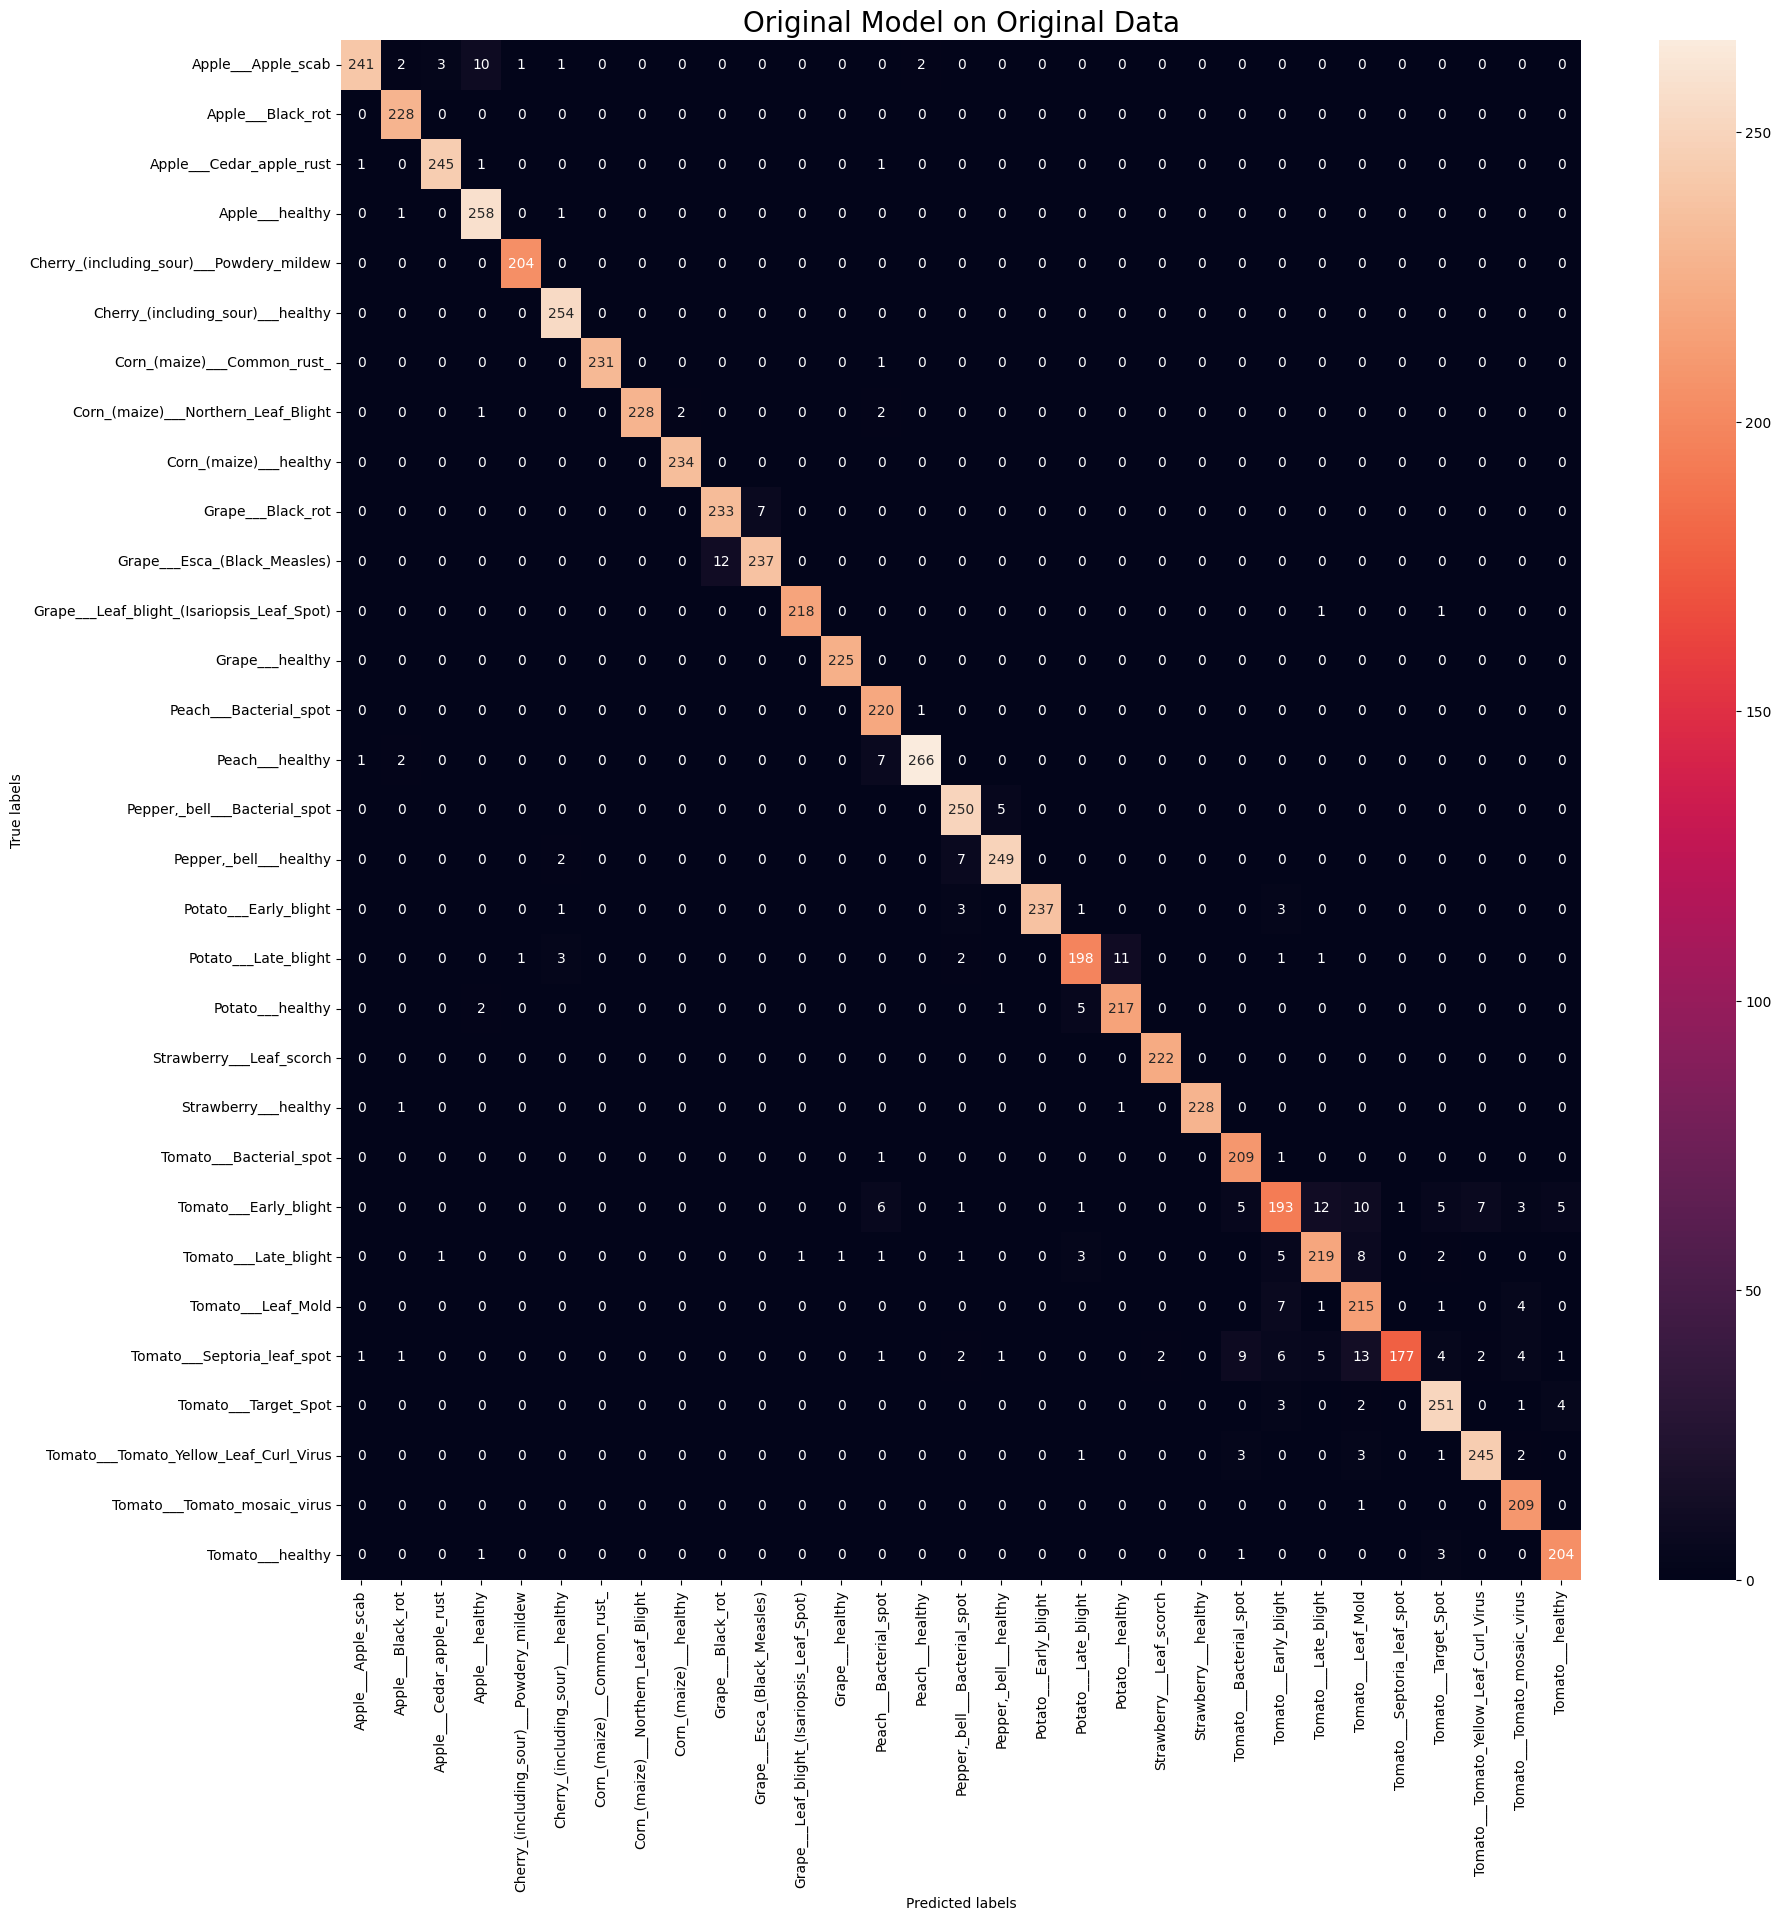

In [20]:
create_model_confusion_matrix(orig_model, orig_test_generator, 
                              "Original_Model_on_Original_Data", orig_test_df, 
                              orig_orig_predictions)

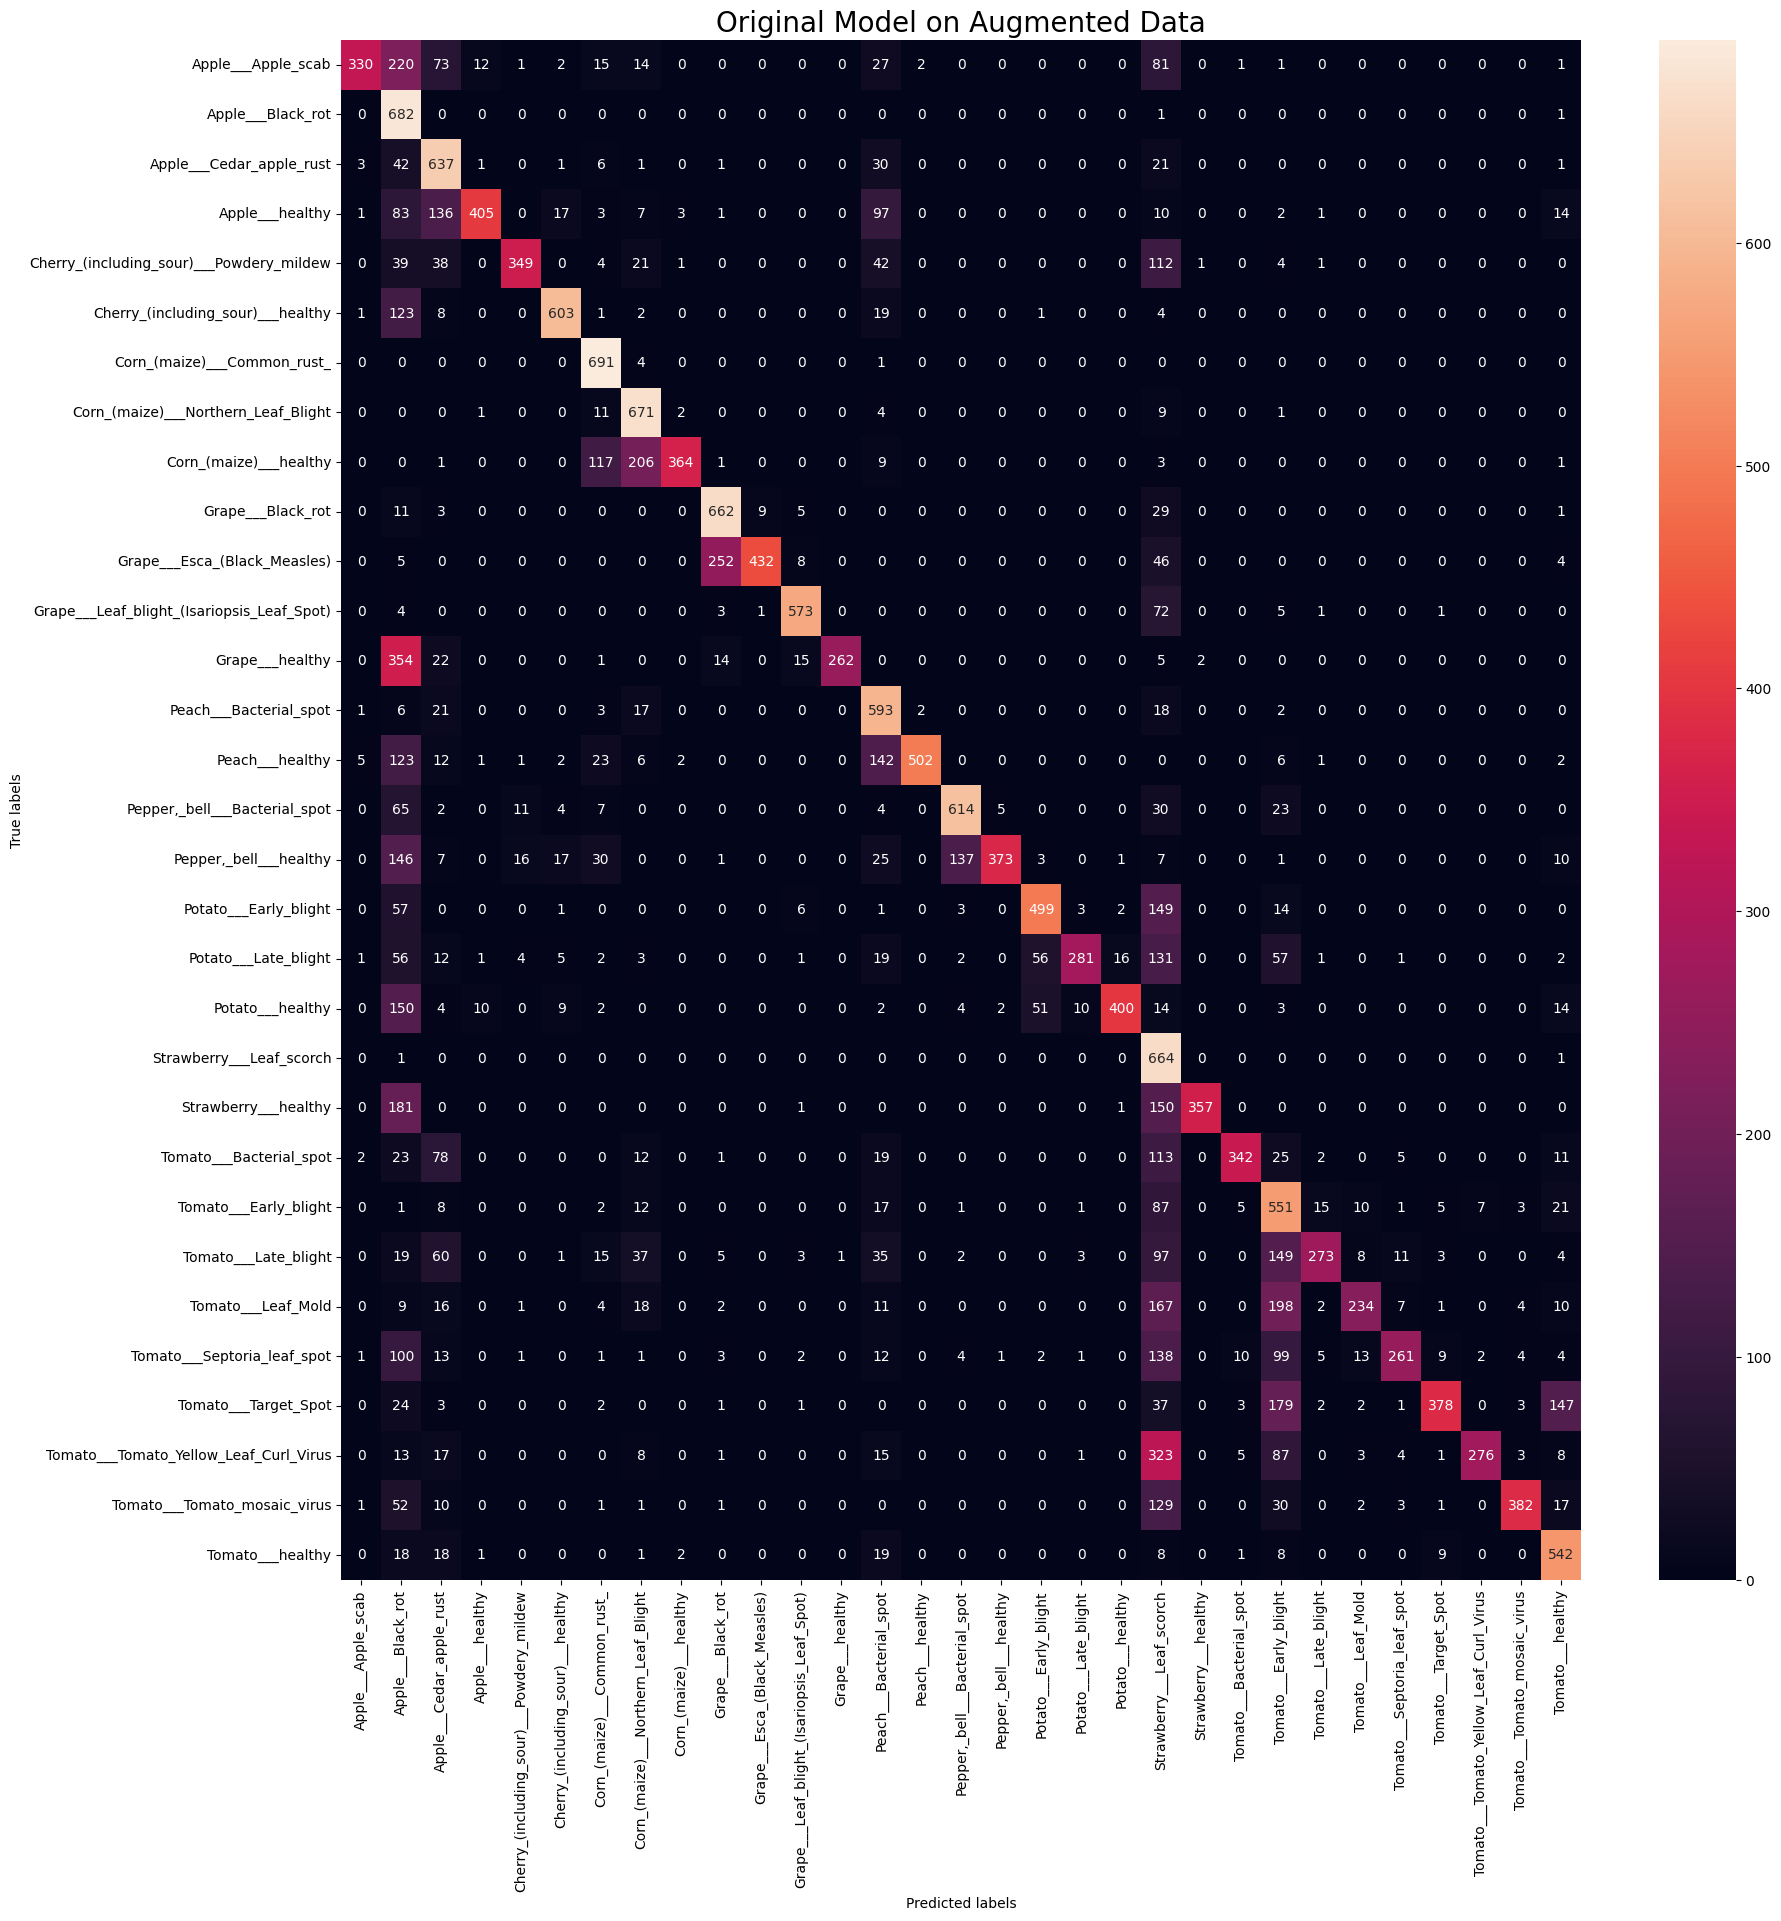

In [21]:
create_model_confusion_matrix(orig_model, aug_test_generator, 
                              "Original_Model_on_Augmented_Data", aug_test_df, 
                              orig_aug_predictions)

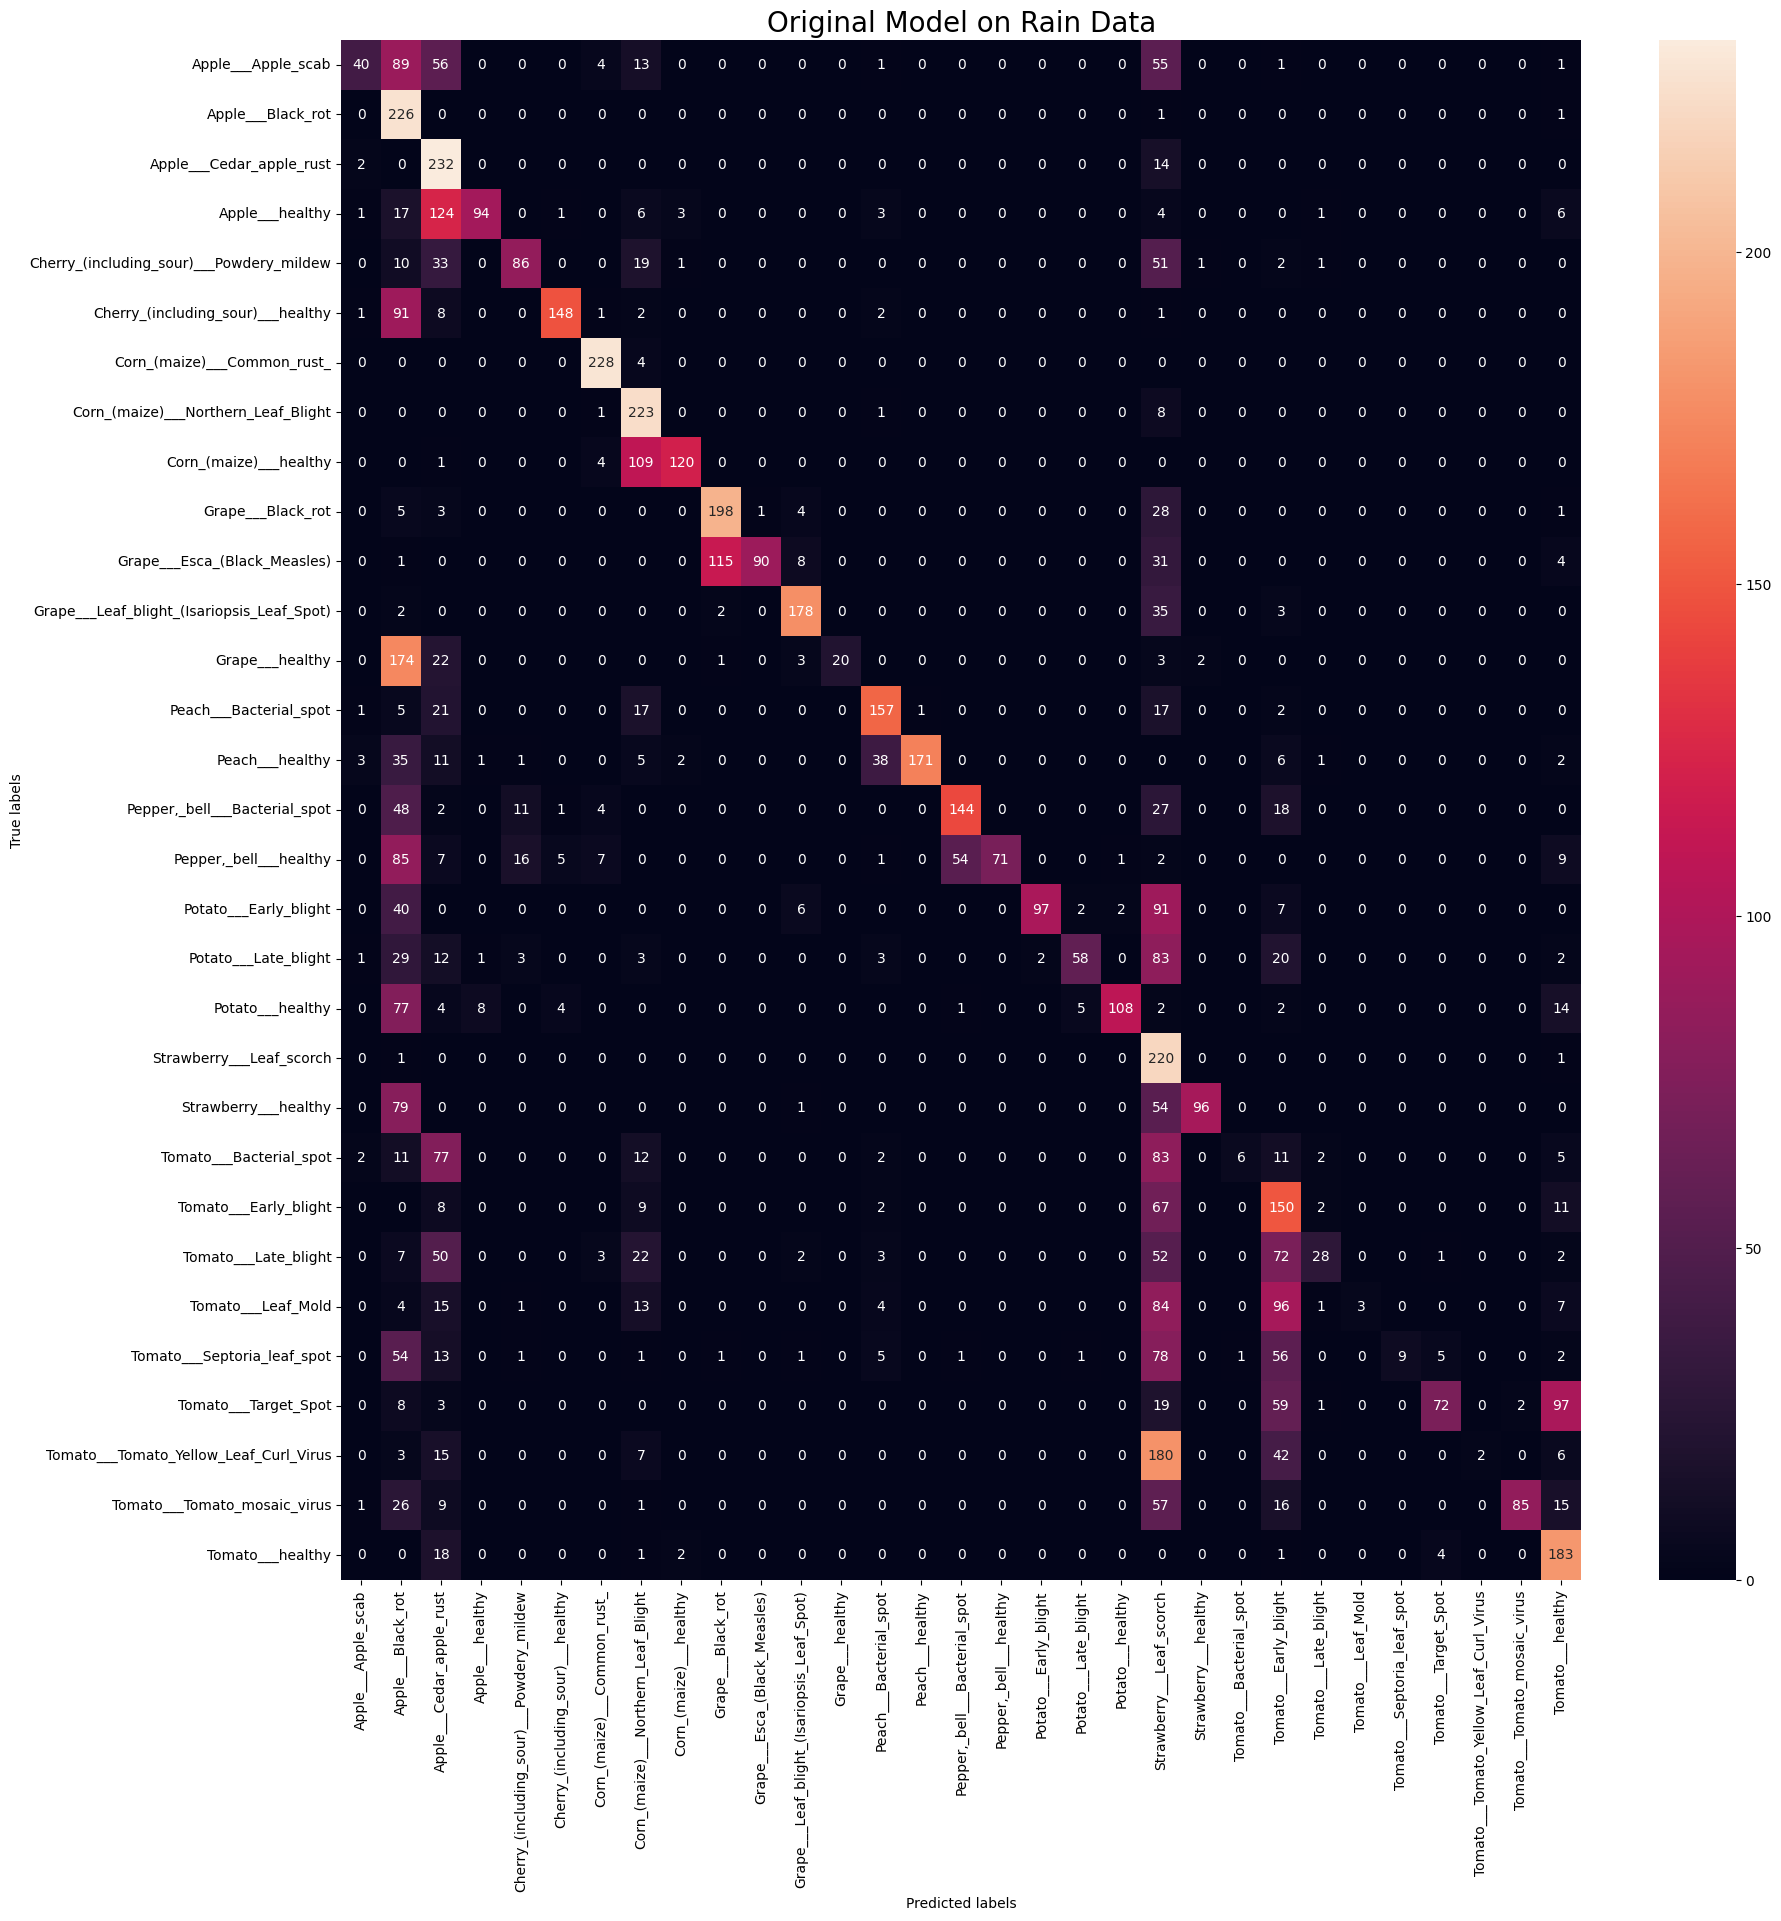

In [22]:
create_model_confusion_matrix(orig_model, rain_test_generator, 
                              "Original_Model_on_Rain_Data", rain_test_df, 
                              orig_rain_predictions)

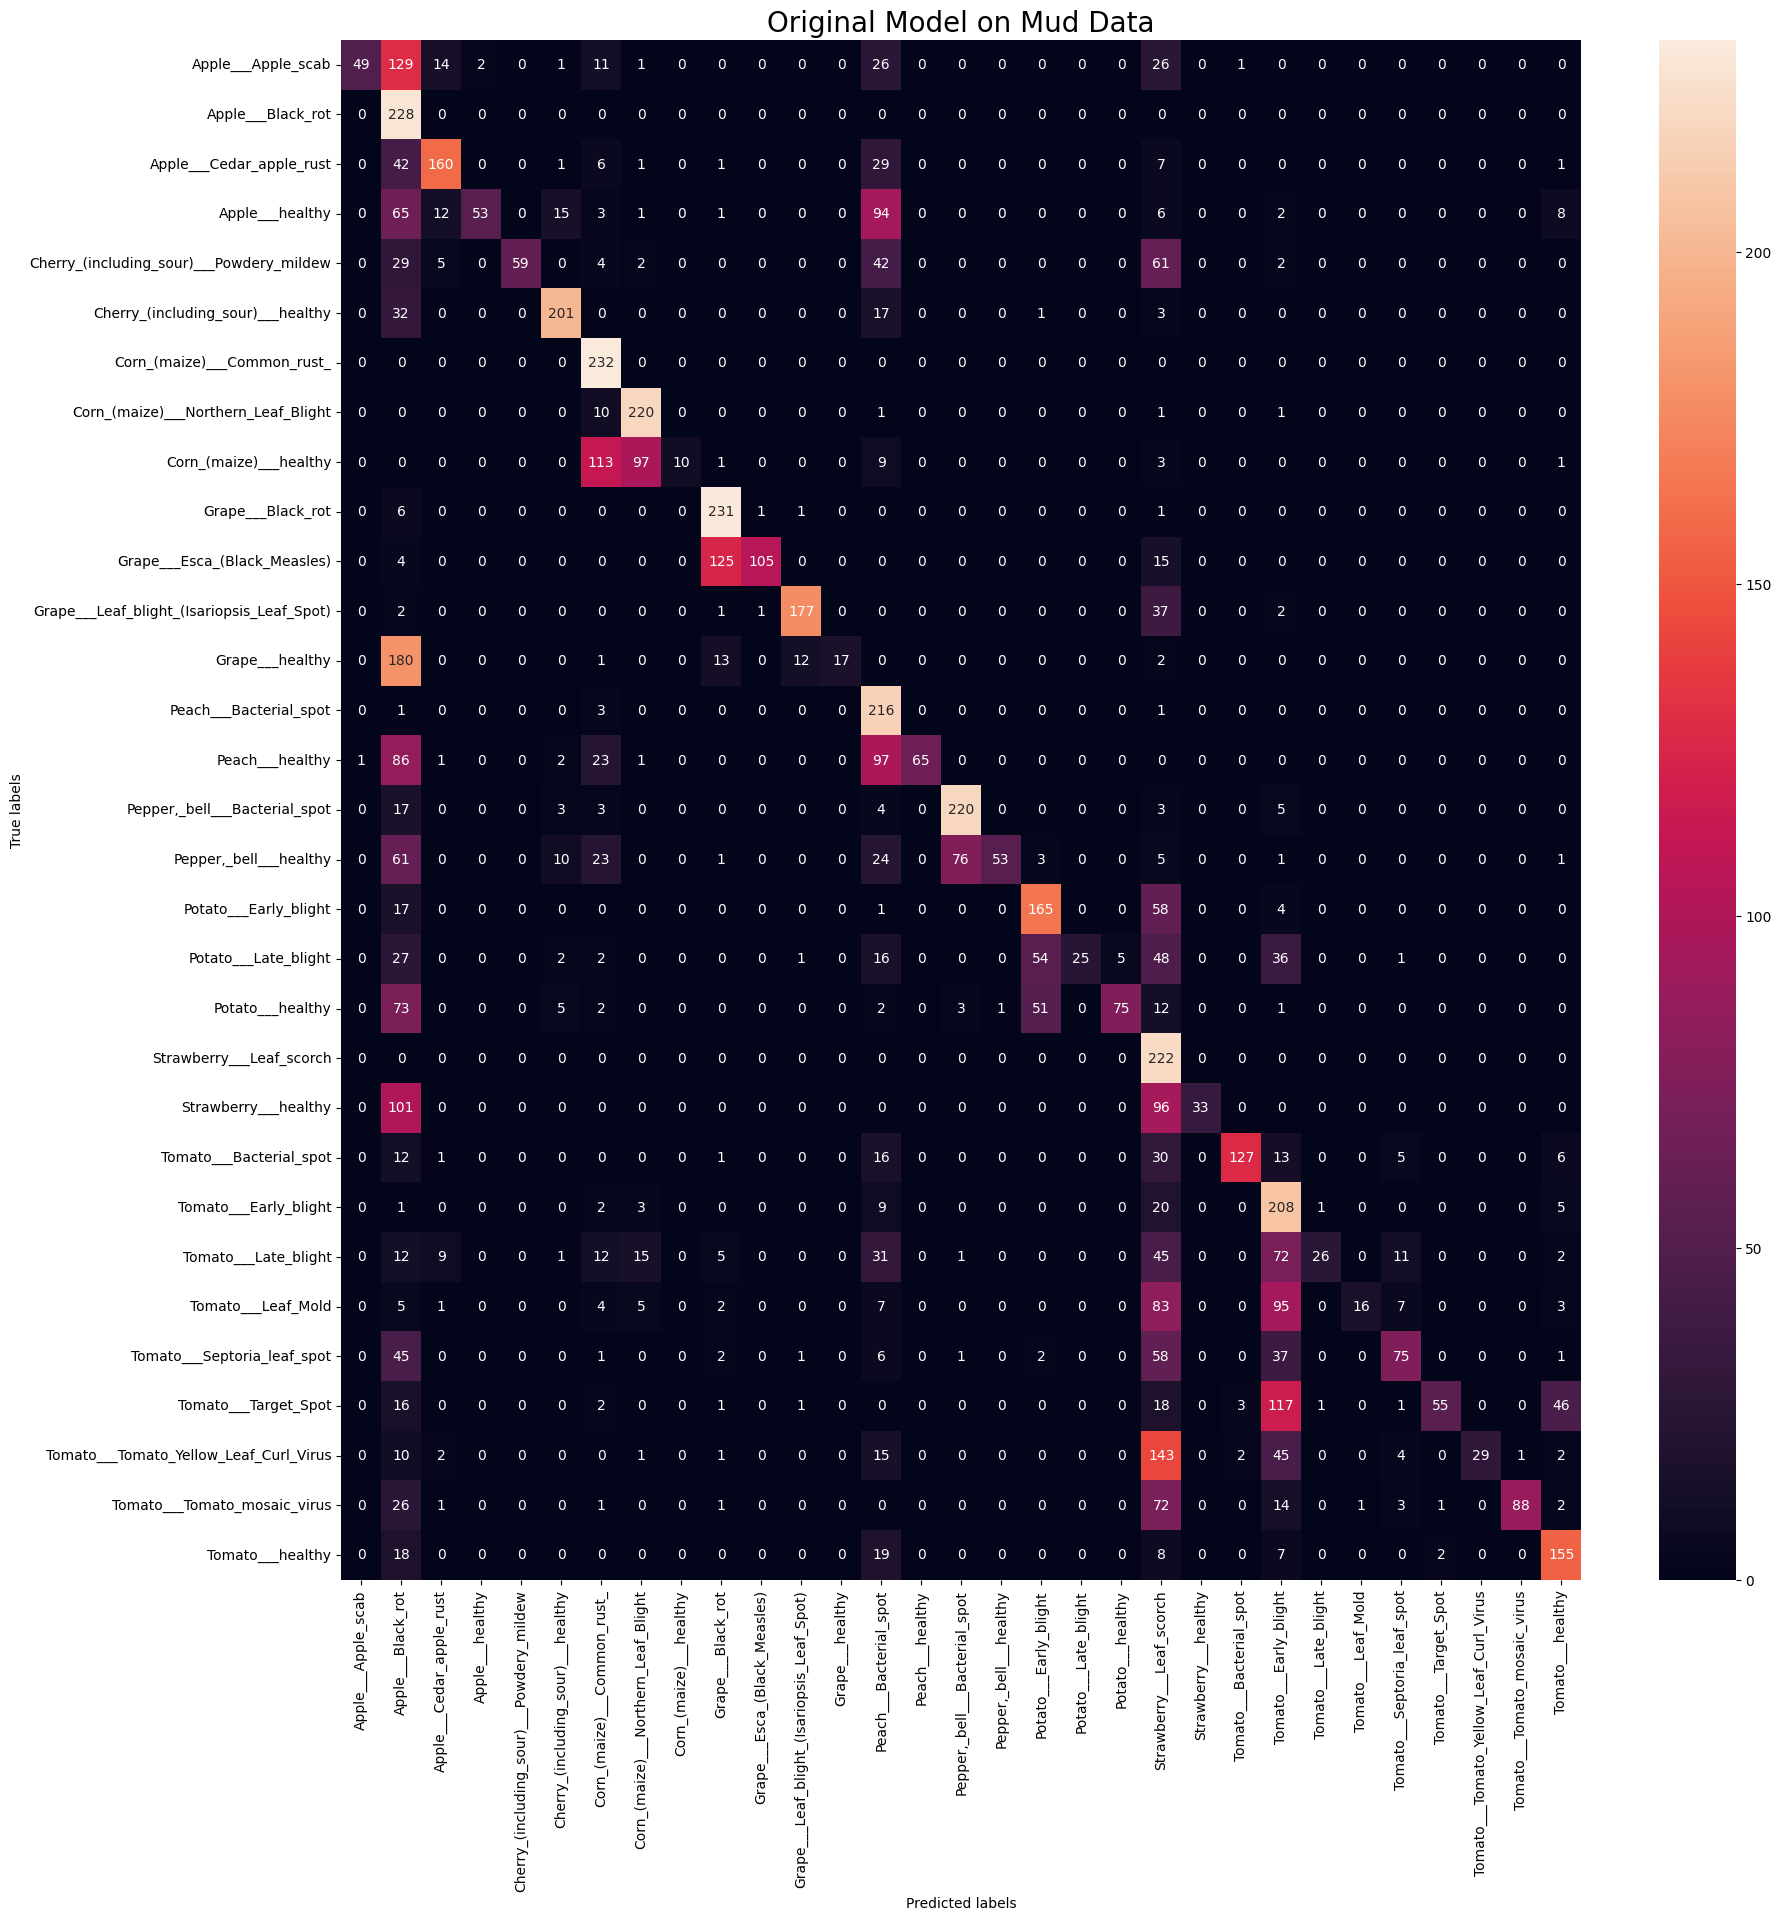

In [23]:
create_model_confusion_matrix(orig_model, mud_test_generator, 
                              "Original_Model_on_Mud_Data", mud_test_df, 
                              orig_mud_predictions)

# CM for Original Model

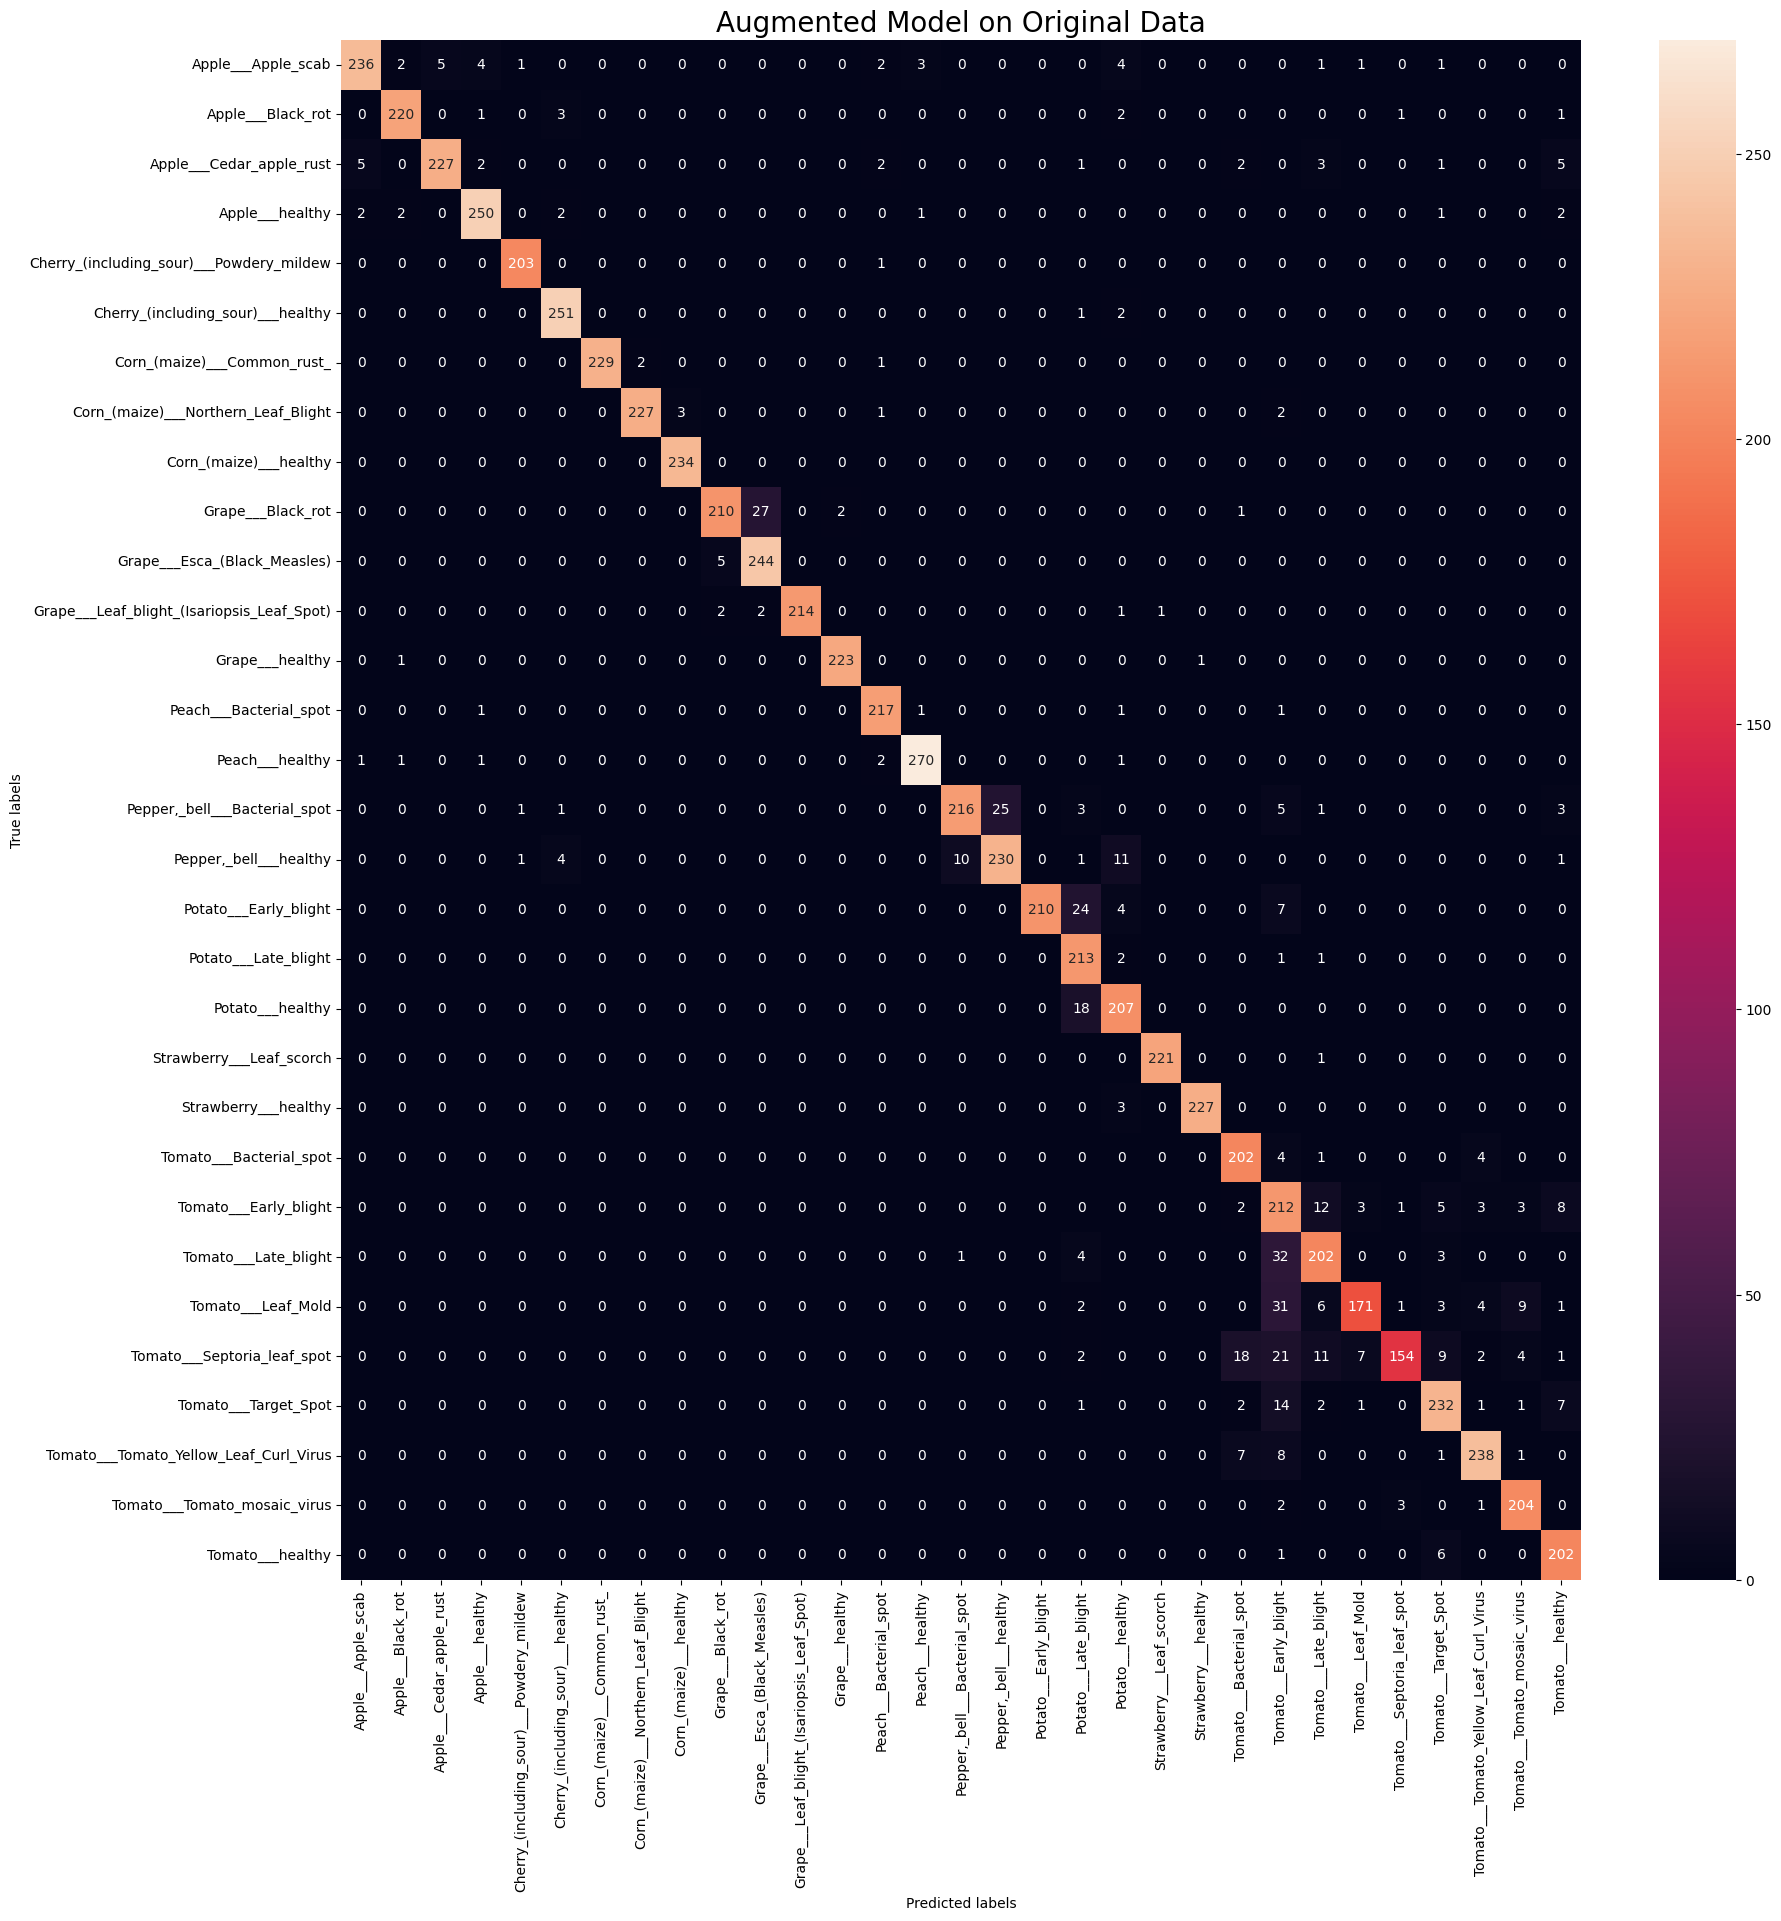

In [24]:
create_model_confusion_matrix(aug_model, orig_test_generator, 
                              "Augmented_Model_on_Original_Data", orig_test_df, 
                              aug_orig_predictions)

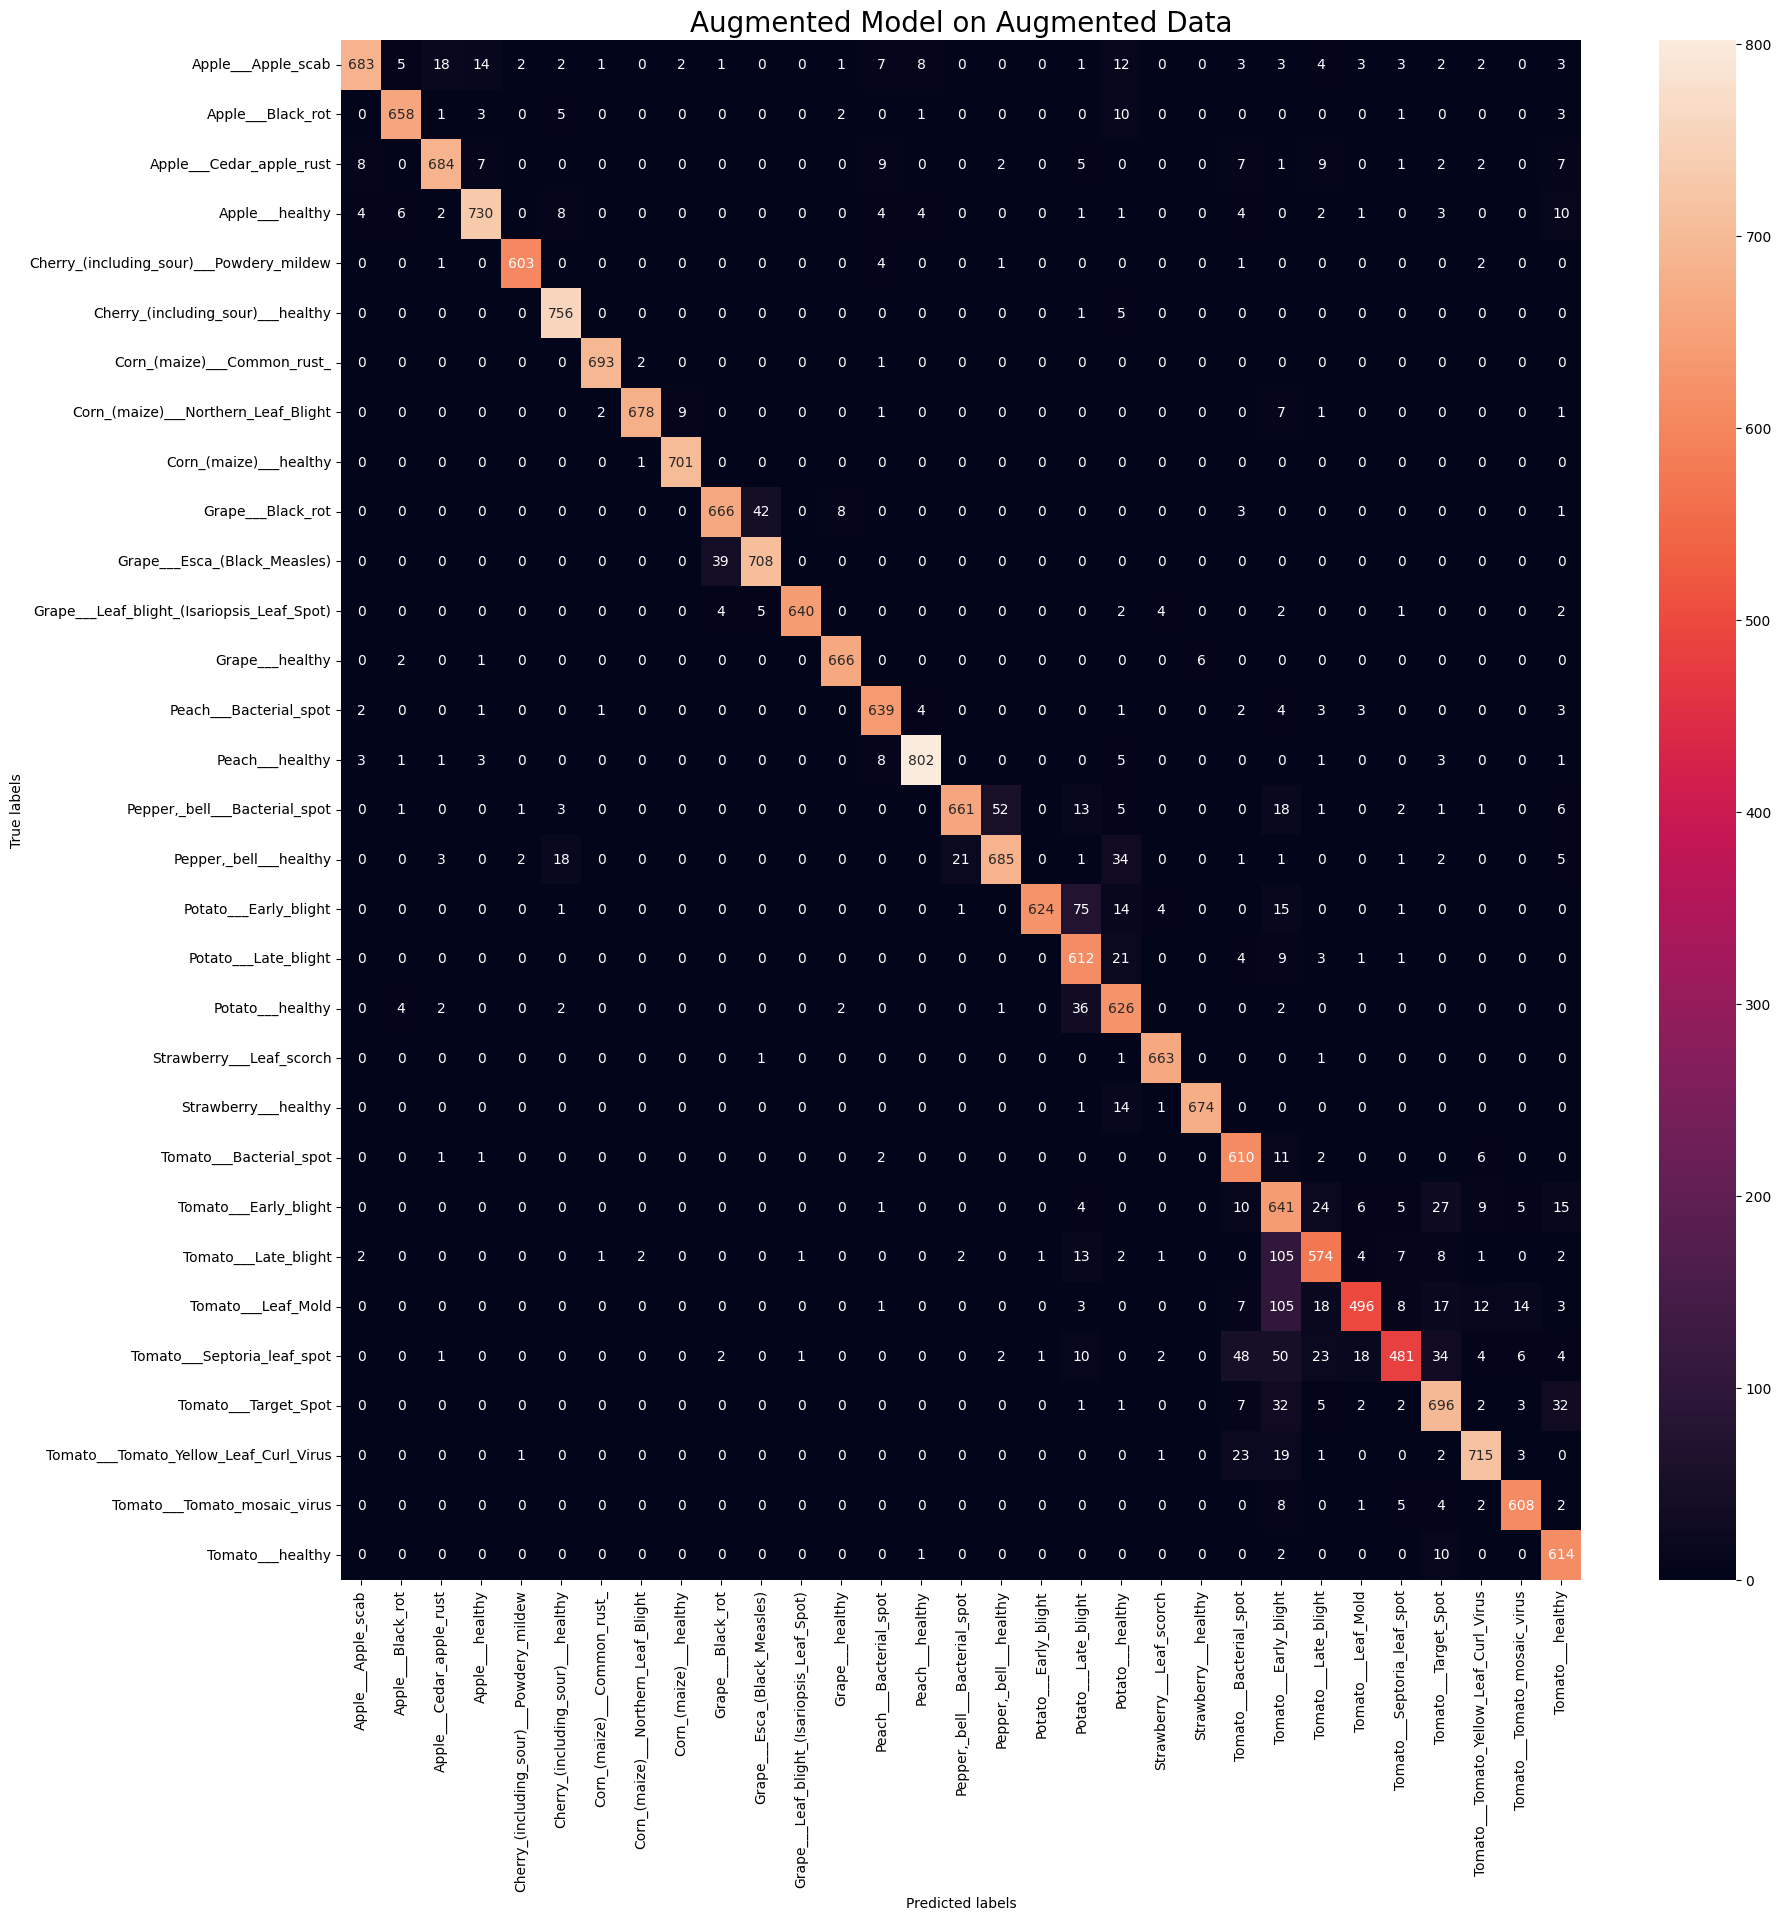

In [25]:
create_model_confusion_matrix(aug_model, aug_test_generator, 
                              "Augmented_Model_on_Augmented_Data", aug_test_df, 
                              aug_aug_predictions)

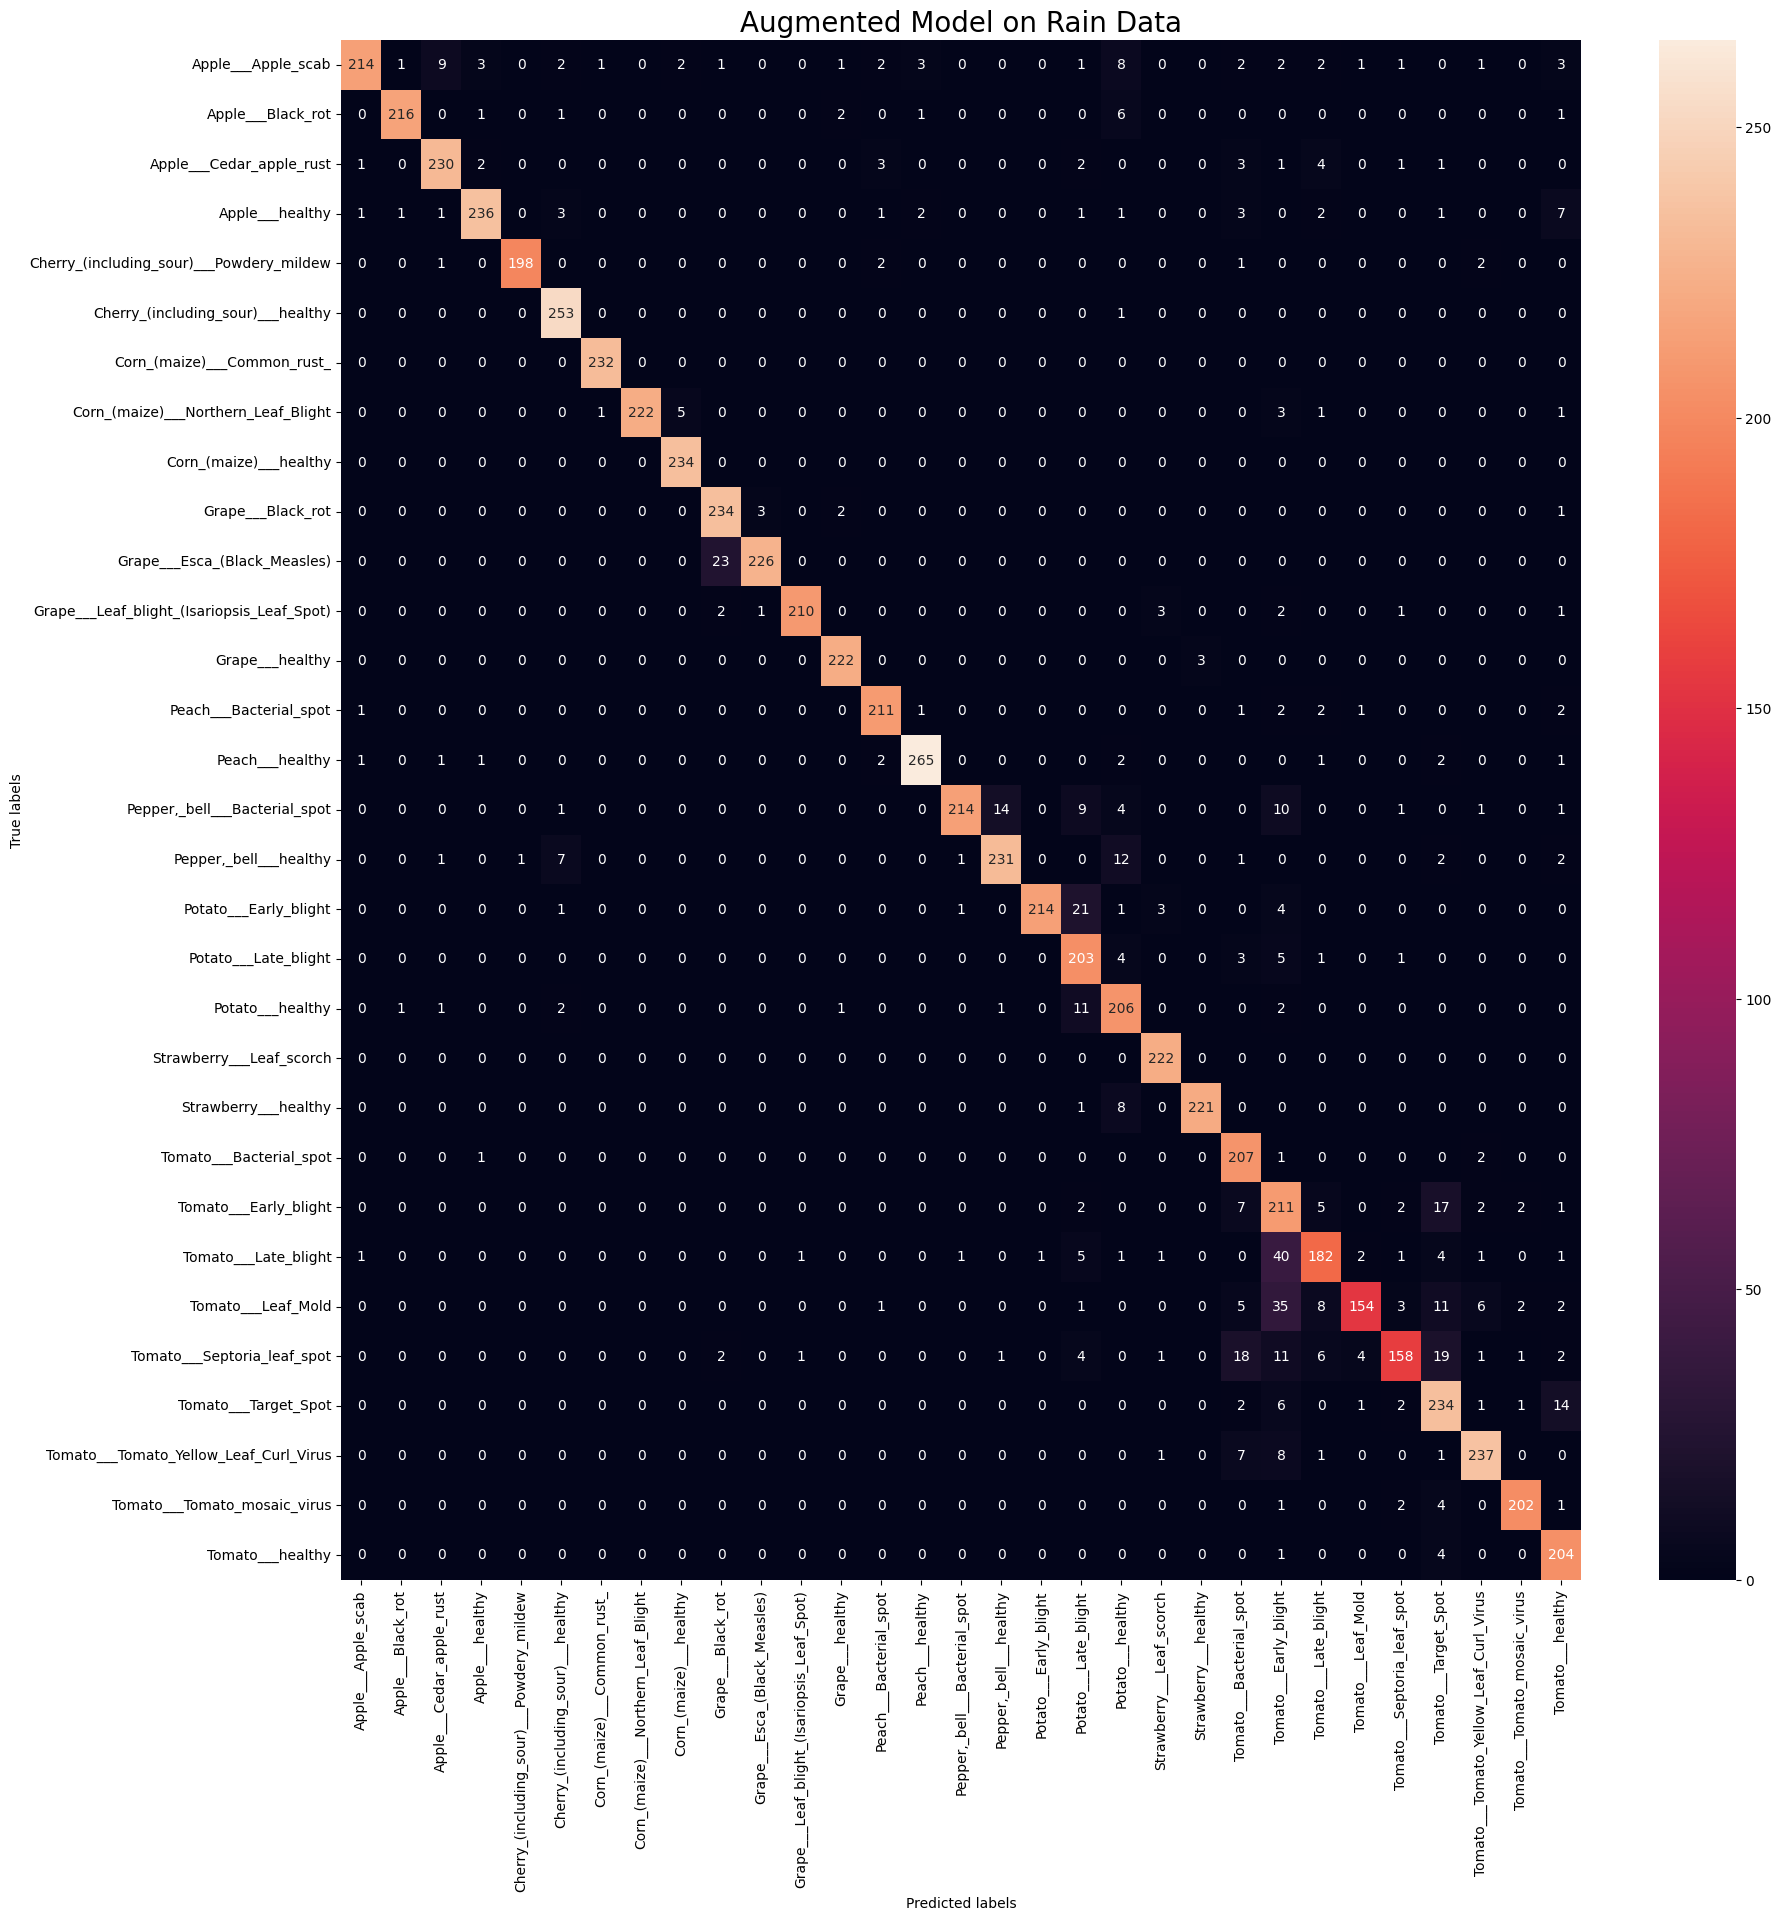

In [26]:
create_model_confusion_matrix(aug_model, rain_test_generator, 
                              "Augmented_Model_on_Rain_Data", rain_test_df, 
                              aug_rain_predictions)

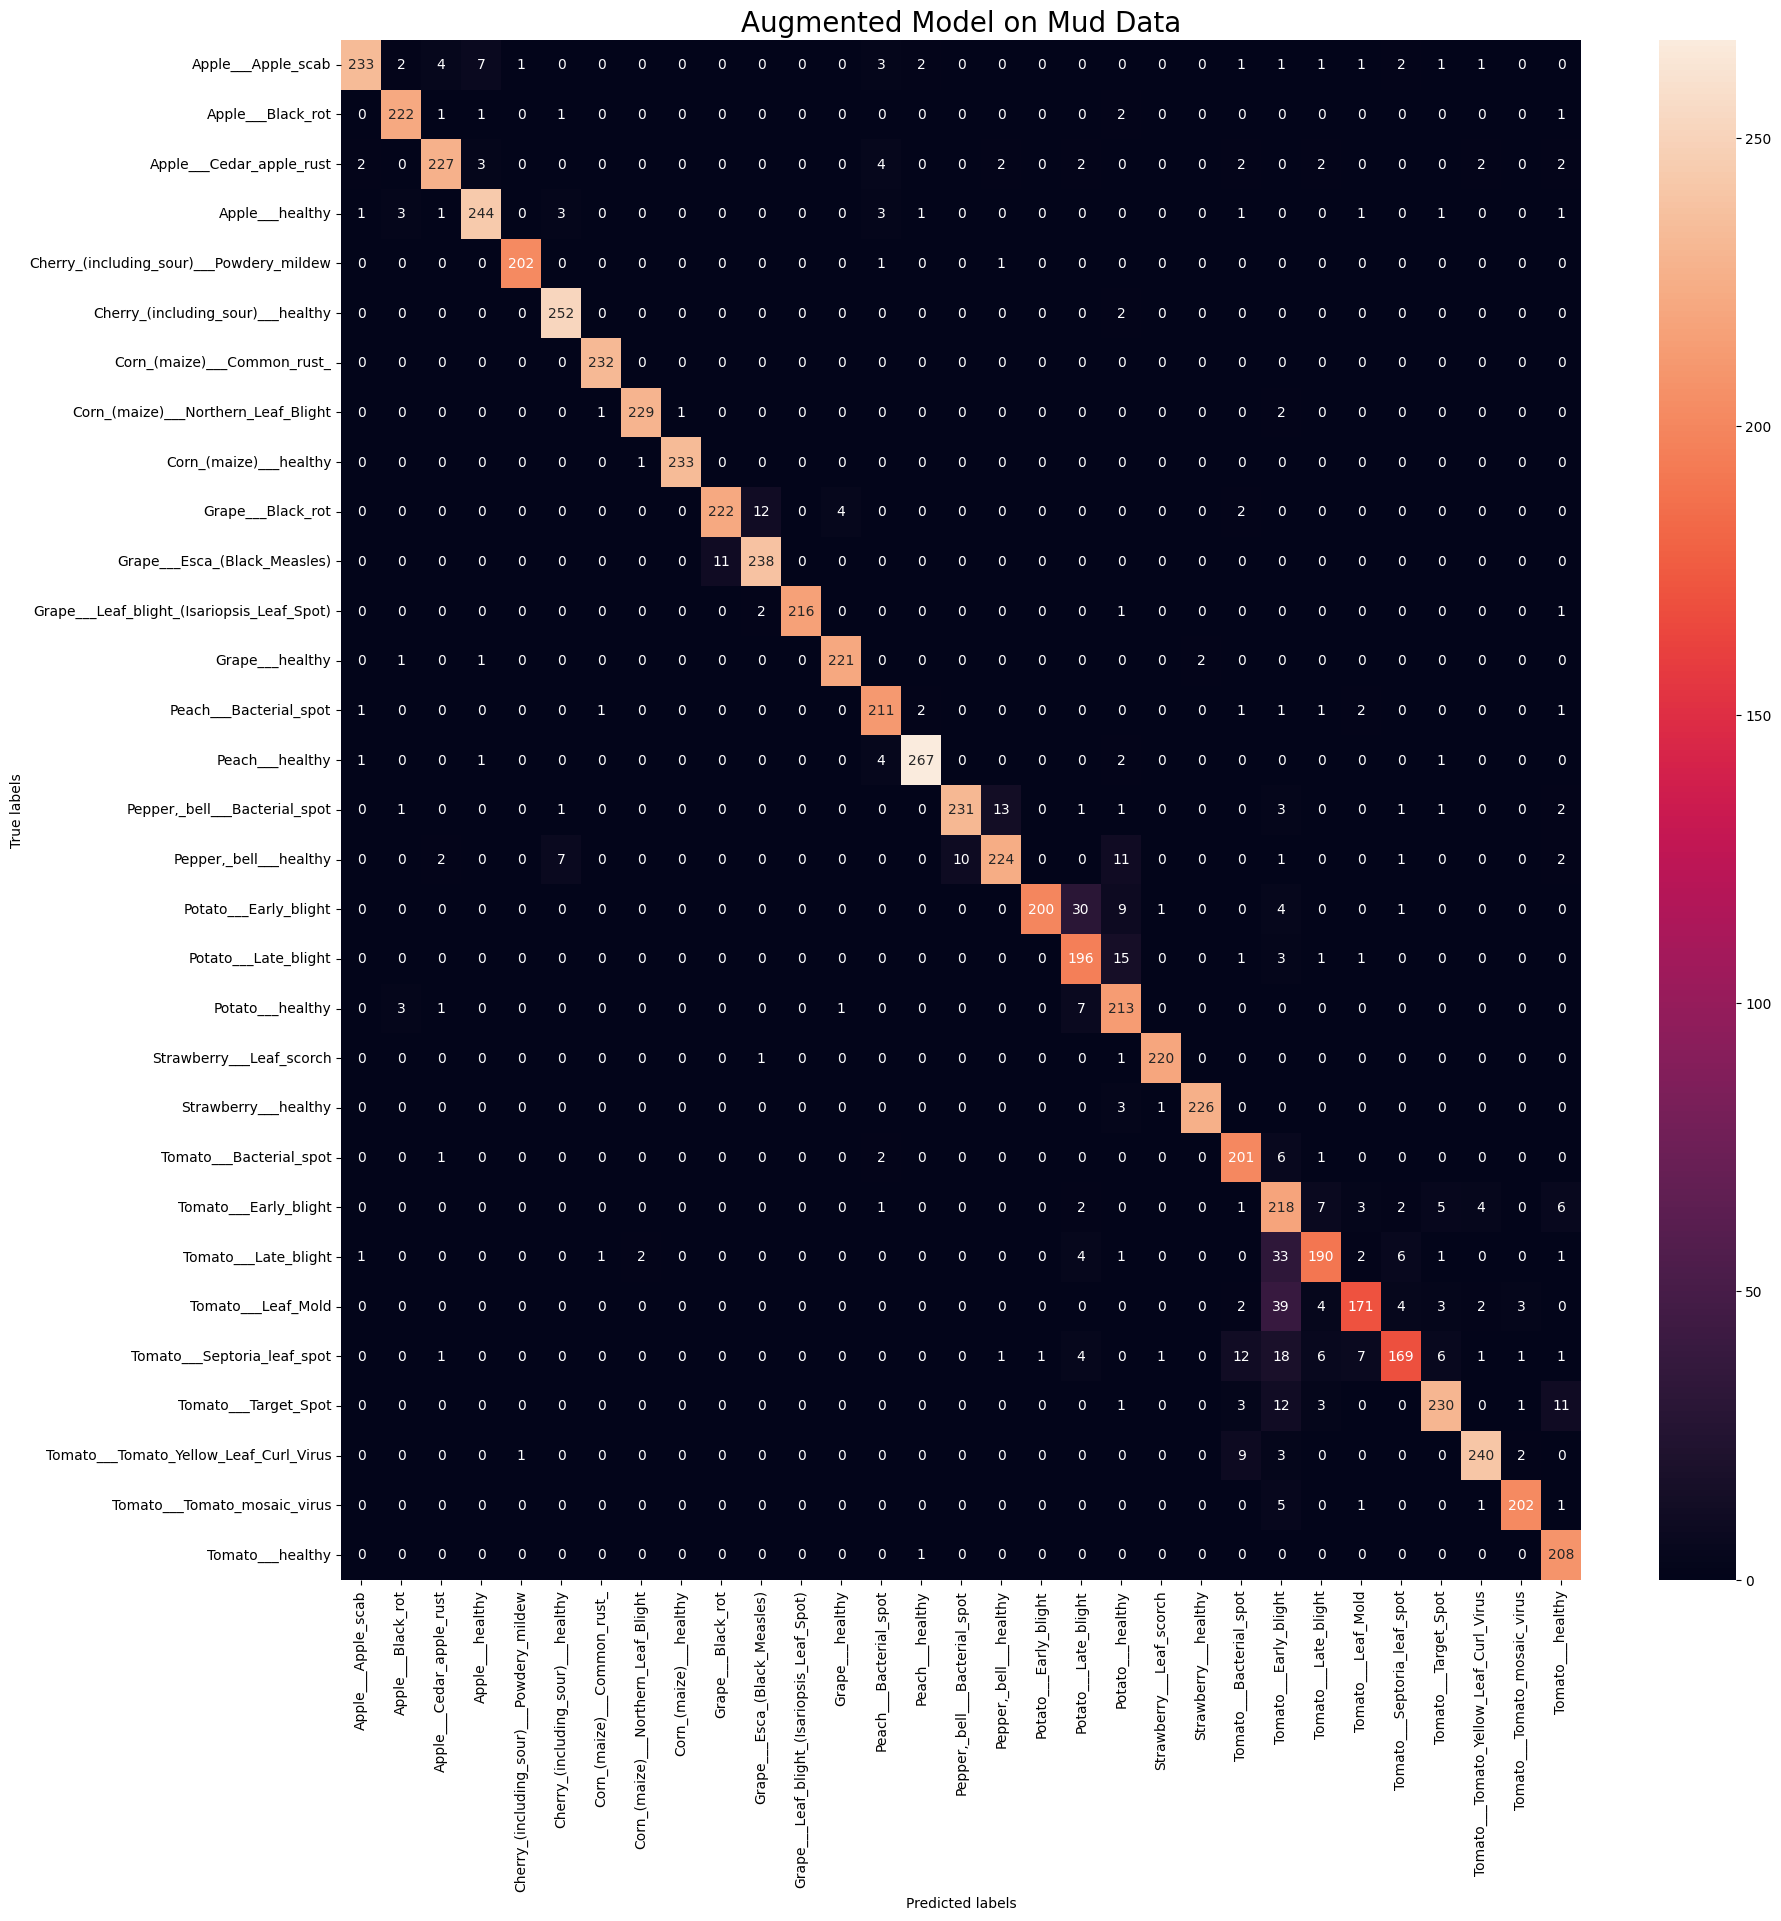

In [27]:
create_model_confusion_matrix(aug_model, mud_test_generator, 
                              "Augmented_Model_on_Mud_Data", mud_test_df, 
                              aug_mud_predictions)